In [136]:
# pip install xgboost

In [137]:
# pip install hyperopt
#https://hyperopt.github.io/hyperopt/?source=post_page

**Install Libraries**

In [138]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.preprocessing import StandardScaler




**Load dataset (football_cleaned_supervised.csv)**

In [139]:
def load_dataset(data):
    df = pd.read_csv(data)
   
    return df


In [140]:
df_football= load_dataset('cleaned_files/football_clean_supervised.csv')

In [141]:
df_football.head(5)

,Unnamed: 0,NAME,GRADE,AGE,SKILL,STARCOLL,NUMOFF,POS,HEIGHT_IN,WEIGHT_LBS,...,TIK_LONG,TOT_FOL,SPORT,RECRUIT_YEAR,EXP_MONTHS,EXP_YEARS,institution_name_short,ClassificationCode,REV_MEN,EXP_MEN
0,0,Arch Manning,2.0,18.28281,99.53,Texas,18.0,1.0,75.5,220.0,...,8900.0,73900.0,football,2023.0,2.0,0.172603,Texas,1.0,161532860.0,50633156.0
1,1,Anthony Hill,2.0,18.00000,97.87,Texas,25.0,8.0,73.5,225.0,...,0.0,13100.0,football,2023.0,2.0,0.172603,Texas,1.0,161532860.0,50633156.0
2,2,CJ Baxter Jr.,2.0,18.00000,97.26,Texas,25.0,9.0,73.0,216.0,...,1700.0,10900.0,football,2023.0,2.0,0.172603,Texas,1.0,161532860.0,50633156.0
3,3,Johntay Cook II,2.0,18.00000,97.23,Texas,25.0,3.0,71.0,175.0,...,136000.0,153800.0,football,2023.0,2.0,0.172603,Texas,1.0,161532860.0,50633156.0
4,4,Malik Muhammad,2.0,19.00000,96.22,Texas,25.0,7.0,72.0,180.0,...,8100.0,16200.0,football,2023.0,2.0,0.172603,Texas,1.0,161532860.0,50633156.0


In [142]:
#remove Unnamed:0 and Sport column- not necessary 
def drop_col(df):
    df=df.drop(columns=['Unnamed: 0', 'SPORT'])
    return df

In [143]:
df_football = drop_col(df_football)

In [144]:
df_football.isna().sum()

NAME                      0
GRADE                     0
AGE                       0
SKILL                     0
STARCOLL                  0
NUMOFF                    0
POS                       0
HEIGHT_IN                 0
WEIGHT_LBS                0
COLLDIST_MI               0
NILVAL_LONG_USD           0
INSTA_LONG                0
TWIT_LONG                 0
TIK_LONG                  0
TOT_FOL                   0
RECRUIT_YEAR              0
EXP_MONTHS                0
EXP_YEARS                 0
institution_name_short    0
ClassificationCode        0
REV_MEN                   0
EXP_MEN                   0
dtype: int64

In [145]:
# df_football.shape
df_football.dtypes

NAME                       object
GRADE                     float64
AGE                       float64
SKILL                     float64
STARCOLL                   object
NUMOFF                    float64
POS                       float64
HEIGHT_IN                 float64
WEIGHT_LBS                float64
COLLDIST_MI               float64
NILVAL_LONG_USD           float64
INSTA_LONG                float64
TWIT_LONG                 float64
TIK_LONG                  float64
TOT_FOL                   float64
RECRUIT_YEAR              float64
EXP_MONTHS                float64
EXP_YEARS                 float64
institution_name_short     object
ClassificationCode        float64
REV_MEN                   float64
EXP_MEN                   float64
dtype: object

In [146]:

# Extract feature and target arrays
X, y = df_football.drop('NILVAL_LONG_USD', axis=1), df_football[['NILVAL_LONG_USD']]

In [147]:
# X.head()

Dataset has 3 categorical featurs (NAME, STARCOLL, institution_name_short). XGBoost has the ability to internally deal with categoricals.Enable this feature by castingthe categorical columns into Pandas category data type (by default, they are treated as text columns):

In [148]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
   X[col] = X[col].astype('category')

In [149]:
X.dtypes

NAME                      category
GRADE                      float64
AGE                        float64
SKILL                      float64
STARCOLL                  category
NUMOFF                     float64
POS                        float64
HEIGHT_IN                  float64
WEIGHT_LBS                 float64
COLLDIST_MI                float64
INSTA_LONG                 float64
TWIT_LONG                  float64
TIK_LONG                   float64
TOT_FOL                    float64
RECRUIT_YEAR               float64
EXP_MONTHS                 float64
EXP_YEARS                  float64
institution_name_short    category
ClassificationCode         float64
REV_MEN                    float64
EXP_MEN                    float64
dtype: object

**Split data into test and train (0.20 test)**

In [150]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


XGBoost comes with its own class for storing datasets called DMatrix. It is a highly optimized class for memory and speed. That's why converting datasets into this format is a requirement for the native XGBoost API. Native API of XGBoost contains some excellent features that Scikit-Learn API doesn’t support

In [151]:

# Create regression matrices
#class accepts both the training features and the labels- enable_categorical = True)
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

Choose a value for the objective parameter- RMSE, minimizes the square root of the squared sum of the differences between actual and predicted values. Objective functions and specified hyperparameters specified in params dictionary.

In [152]:
#num_boost_round =  number of boosting rounds. Hyperparameter to be tuned. Initally set to 100.
#training dataset = dtrain_reg
#function trains the XGBoost regression model with the specified hyperparameters and returns the trained model.
#tree booster always outperforms the linear booster (which israrely used)


# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "hist"}

num_boost_round = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=num_boost_round,
)

**Evaluation** During boosting rounds, the model object has learned all the patterns of the training set. Perform testing.

In [153]:
preds = model.predict(dtest_reg)

In [154]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

mae = mean_absolute_error(y_test, preds)
print(f"MAE of the base model: {mae:.3f}")


RMSE of the base model: 207216.846
MAE of the base model: 149360.500


**Using Validation Sets during Training** https://www.datacamp.com/tutorial/xgboost-in-python
Use evaluation arrays that allow us to see model performance as it gets improved incrementally across boosting rounds.

In [155]:
#set parameters again
params = {"objective": "reg:squarederror", "tree_method": "hist"}
num_boost_round = 100

#create list of two tupleshat each contain two elements. 
# #The first element is the array for the model to evaluate.
#The second is the array’s name.

evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

#Pass array to evals parameter of xgb.train to see model boosting performance after each round

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=num_boost_round,
   evals=evals,
   verbose_eval=10 # Every ten rounds   #forces XGBoost to print performance updates every vebose_eval rounds
)

[0]	train-rmse:232839.44396	validation-rmse:179583.05099
[10]	train-rmse:38468.93716	validation-rmse:157641.42563
[20]	train-rmse:10827.30977	validation-rmse:156480.07296
[30]	train-rmse:4045.93682	validation-rmse:156004.48672
[40]	train-rmse:1738.29290	validation-rmse:155904.02713
[50]	train-rmse:720.54474	validation-rmse:155875.09063
[60]	train-rmse:281.44186	validation-rmse:155894.99480
[70]	train-rmse:93.87351	validation-rmse:155897.54192
[80]	train-rmse:36.37500	validation-rmse:155898.30804
[90]	train-rmse:12.46337	validation-rmse:155897.71815
[99]	train-rmse:4.82532	validation-rmse:155897.59860


RMSE reduced from 179583 to 155897
Trying 5000 rounds with verbosity 250
Reaches training and validation loss before 500. 

In [156]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
num_boost_round = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=num_boost_round,
   evals=evals,
   verbose_eval=250
)

[0]	validation-rmse:179583.05099	train-rmse:232839.44396
[250]	validation-rmse:155897.56961	train-rmse:0.02398
[500]	validation-rmse:155897.56961	train-rmse:0.02398
[750]	validation-rmse:155897.56961	train-rmse:0.02398
[1000]	validation-rmse:155897.56961	train-rmse:0.02398
[1250]	validation-rmse:155897.56961	train-rmse:0.02398
[1500]	validation-rmse:155897.56961	train-rmse:0.02398
[1750]	validation-rmse:155897.56961	train-rmse:0.02398
[2000]	validation-rmse:155897.56961	train-rmse:0.02398
[2250]	validation-rmse:155897.56961	train-rmse:0.02398
[2500]	validation-rmse:155897.56961	train-rmse:0.02398
[2750]	validation-rmse:155897.56961	train-rmse:0.02398
[3000]	validation-rmse:155897.56961	train-rmse:0.02398
[3250]	validation-rmse:155897.56961	train-rmse:0.02398
[3500]	validation-rmse:155897.56961	train-rmse:0.02398
[3750]	validation-rmse:155897.56961	train-rmse:0.02398
[4000]	validation-rmse:155897.56961	train-rmse:0.02398
[4250]	validation-rmse:155897.56961	train-rmse:0.02398
[4500]	vali

**Using Early Stopping** Forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

In [157]:
n = 10000


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=num_boost_round,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=50  #Activiate early stopping
)




[0]	validation-rmse:179583.05099	train-rmse:232839.44396
[50]	validation-rmse:155875.09063	train-rmse:720.54474
[100]	validation-rmse:155897.60612	train-rmse:4.30692
[150]	validation-rmse:155897.57014	train-rmse:0.04143
[200]	validation-rmse:155897.57030	train-rmse:0.02512
[250]	validation-rmse:155897.56961	train-rmse:0.02398
[269]	validation-rmse:155897.56961	train-rmse:0.02398


Training stopped after Round 269. <br>
**Perform K-Fold Cross-Validation**

In [158]:
params = {"objective": "reg:squarederror", "tree_method": "hist"}
n = 1000

results = xgb.cv(
   params, 
   dtrain_reg,
   num_boost_round=num_boost_round,
   nfold=5,
   early_stopping_rounds=20
)

In [159]:
#df containing each folds results
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,232827.836324,25911.987976,262270.231396,111125.625739
1,183404.741051,22019.227188,250053.457446,111581.256171
2,147169.076968,18985.128355,241413.810697,112692.567455
3,119875.037706,16741.528216,236047.145392,113908.354654
4,98916.861318,14603.766735,232304.709498,114910.477273


In [160]:
#find the best score by taking the minimum of the test-rmse-mean column
best_rmse = results['test-rmse-mean'].min()

best_rmse
print(f"Best RMSE of the base model: {best_rmse:.3f}")

Best RMSE of the base model: 225010.393


**Feature Importance** Which features are most influential in making NIL prediction

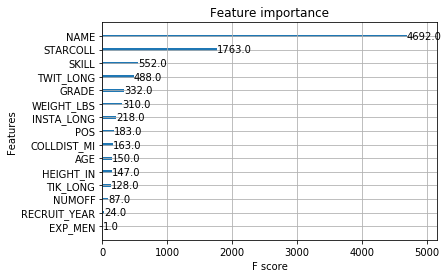

In [161]:
from xgboost import plot_importance

plot_importance(model, max_num_features=22)

**Hyperparameter tuning**

In [162]:
# # Define hyperparameters
# params = {"objective": "reg:squarederror", "tree_method": "hist"}


params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective': 'reg:squarederror',
    'tree_method': 'hist'
}

num_boost_round = 999
params['eval_metric'] = "mae"

# evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]

model = xgb.train(
    params = params,
    dtrain =dtrain_reg,
    num_boost_round=num_boost_round,
    # evals=evals,
    evals=[(dtest_reg, "Test")],
    early_stopping_rounds=10
)

preds = model.predict(dtest_reg)

print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))




[0]	Test-mae:120758.94419
[1]	Test-mae:102986.61452
[2]	Test-mae:92342.13903
[3]	Test-mae:87560.44415
[4]	Test-mae:84765.73261
[5]	Test-mae:83849.20451
[6]	Test-mae:81800.84306
[7]	Test-mae:81523.91439
[8]	Test-mae:81109.92638
[9]	Test-mae:80426.51620
[10]	Test-mae:80892.42851
[11]	Test-mae:80176.35470
[12]	Test-mae:79998.18066
[13]	Test-mae:80324.95655
[14]	Test-mae:80042.98584
[15]	Test-mae:79863.27790
[16]	Test-mae:79752.87190
[17]	Test-mae:79749.15833
[18]	Test-mae:79769.18335
[19]	Test-mae:79687.04254
[20]	Test-mae:79418.33087
[21]	Test-mae:79378.42912
[22]	Test-mae:79398.98499
[23]	Test-mae:79417.32752
[24]	Test-mae:79280.81567
[25]	Test-mae:79296.20053
[26]	Test-mae:79191.39453
[27]	Test-mae:79137.34066
[28]	Test-mae:79177.34134
[29]	Test-mae:79169.39510
[30]	Test-mae:79154.25652
[31]	Test-mae:79207.96480
[32]	Test-mae:79178.61975
[33]	Test-mae:79212.36350
[34]	Test-mae:79182.71750
[35]	Test-mae:79148.63687
[36]	Test-mae:79120.81106
[37]	Test-mae:79100.27339
[38]	Test-mae:79077.

Baseline was:<br>RMSE of the base model: 206653.627
<br> MAE of the base model: 148719.134

In [163]:
#cross validation with current parameters
# params = {"objective": "reg:squarederror", "tree_method": "hist"}
cv_results = xgb.cv(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae', 'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,233375.894167,21465.654955,115027.575739,3256.325344,265156.590260,99862.087315,134229.264548,18067.766788
1,184047.401386,18273.504240,83184.071831,2447.805042,252444.576054,99102.376017,116960.484692,17378.011929
2,147257.573847,16934.915284,60970.792275,1911.224145,244787.424096,98428.350444,107380.213691,18218.110936
3,120286.853647,15580.974289,45914.256648,1635.560174,239507.851095,98882.362647,100932.462206,19708.226760
4,99186.819600,14487.346131,36219.527199,1597.516132,236227.383115,98975.690162,96957.236405,19769.511561
5,82454.353493,13085.026749,29558.627867,1643.650633,235437.634251,99626.395471,94278.594991,20432.309038
6,69183.103644,11838.523378,24868.496392,1958.404476,235629.860697,100674.537425,92943.190459,21325.942442
7,58297.927380,10433.727291,21171.406330,1784.423965,236439.026935,101650.548979,92522.231822,21828.204289
8,49684.722419,9190.683904,18616.192004,1775.498671,237132.209527,102524.519366,91758.460705,22189.354034
9,42052.805550,8152.731612,16049.496344,1764.726049,238277.295945,103357.001734,91491.083632,22188.547014


In [164]:
# best_mae = cv_results['test-mae-mean'].min()
# best_mae

best_rmse = cv_results['test-rmse-mean'].min()
best_rmse
print(f"Best RMSE CV: {best_rmse:.3f}")
print(f"Best MAE CV: {best_mae:.3f}")

Best RMSE CV: 235437.634
Best MAE CV: 65414.596


Baseline was:<br>RMSE of the base model: 206653.627
<br> MAE of the base model: 148719.134

In [165]:
#tuning max_depth and min_child_weight
'''  max_depth = maximum number of nodes allowed from the root to the farthest leaf of a tree. 
                Deeper trees can model more complex relationships by adding more nodes, 
                but as we go deeper,splits become less relevant and are sometimes only due to noise,
                causing the model to overfit. 
                min_child_weight = minimum weight (or number of samples if all samples have a weight of 1) 
                required in order to create a new node in the tree.
                A smaller min_child_weight allows the algorithm to create children that 
                correspond to fewer samples, thus allowing for more complex trees, 
                but again, more likely to overfit. '''

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae', 'rmse'},
        early_stopping_rounds=10
    )
     # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=9, min_child_weight=5
	MAE 66025.27766862624 for 5 rounds
CV with max_depth=9, min_child_weight=6
	MAE 67020.71357131806 for 5 rounds
CV with max_depth=9, min_child_weight=7
	MAE 65208.85380569308 for 6 rounds
CV with max_depth=10, min_child_weight=5
	MAE 65086.750317141086 for 6 rounds
CV with max_depth=10, min_child_weight=6
	MAE 66542.18403852104 for 4 rounds
CV with max_depth=10, min_child_weight=7
	MAE 65823.68037592822 for 6 rounds
CV with max_depth=11, min_child_weight=5
	MAE 66232.3709738552 for 6 rounds
CV with max_depth=11, min_child_weight=6
	MAE 66146.29288366337 for 5 rounds
CV with max_depth=11, min_child_weight=7
	MAE 65414.59646890471 for 6 rounds
Best params: 10, 5, MAE: 65086.750317141086


In [166]:
#update params
params['max_depth'] = 10
params['min_child_weight'] = 5

In [167]:
#tuning subsample and colsample_bytree
'''   Instead of using the whole training set every time, we can build a 
    tree on slightly different data at each step, 
    which makes it less likely to overfit to a single sample or feature.

subsample =  the fraction of observations (the rows) to subsample at each step. 
By default it is set to 1 meaning that we use all rows.
colsample_bytree = the fraction of features (the columns) to use. 
By default it is set to 1 meaning that we will use all features    '''

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 65086.750317141086 for 6 rounds
CV with subsample=1.0, colsample=0.9
	MAE 67097.1855778156 for 5 rounds
CV with subsample=1.0, colsample=0.8
	MAE 64866.98271194308 for 5 rounds
CV with subsample=1.0, colsample=0.7
	MAE 68223.52738242575 for 6 rounds
CV with subsample=0.9, colsample=1.0
	MAE 66918.26770188738 for 5 rounds
CV with subsample=0.9, colsample=0.9
	MAE 66032.96971689357 for 5 rounds
CV with subsample=0.9, colsample=0.8
	MAE 67432.69890547649 for 5 rounds
CV with subsample=0.9, colsample=0.7
	MAE 68414.73435179456 for 5 rounds
CV with subsample=0.8, colsample=1.0
	MAE 64560.56417079208 for 5 rounds
CV with subsample=0.8, colsample=0.9
	MAE 66753.6083539604 for 5 rounds
CV with subsample=0.8, colsample=0.8
	MAE 68714.97074566832 for 6 rounds
CV with subsample=0.8, colsample=0.7
	MAE 69824.62070699257 for 6 rounds
CV with subsample=0.7, colsample=1.0
	MAE 66006.89182008045 for 5 rounds
CV with subsample=0.7, colsample=0.9
	MAE 66547.2373

In [168]:
#update params
params['subsample'] = 0.8
params['colsample_bytree'] = 1.0

In [169]:
#tuning  eta
import time

'''    eta = controls the learning rate. corresponds to the shrinkage of 
            the weights associated to features after each round/ defines the amount of "correction" 
            at each step
            lower eta makes model more robust to overfitting.
            Usually, the lower the learning rate, the best. 
            With lower eta,  need more boosting rounds, which takes more time to train, 
            sometimes for only marginal improvements


'''
time

%time 
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

    # Update parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
            params,
            dtrain_reg,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

Wall time: 0 ns
CV with eta=0.3
Wall time: 0 ns
	MAE 64560.56417079208 for 5 rounds

CV with eta=0.2
Wall time: 0 ns
	MAE 64274.08786355198 for 9 rounds

CV with eta=0.1
Wall time: 0 ns
	MAE 62565.323619275994 for 20 rounds

CV with eta=0.05
Wall time: 0 ns
	MAE 61202.043722926974 for 39 rounds

CV with eta=0.01
Wall time: 0 ns
	MAE 61241.42267172029 for 203 rounds

CV with eta=0.005
Wall time: 0 ns
	MAE 60860.7320621906 for 418 rounds

Best params: 0.005, MAE: 60860.7320621906


In [170]:
params['eta'] = .005

In [171]:
#final params dictionary
params
{'colsample_bytree': 1.0,
 'eta': 0.005,
'eval_metric': {'mae','rmse'},
'max_depth': 10,
'min_child_weight': 5,
'objective': 'reg:tree',
'subsample': 0.8}

{'colsample_bytree': 1.0,
 'eta': 0.005,
 'eval_metric': {'mae', 'rmse'},
 'max_depth': 10,
 'min_child_weight': 5,
 'objective': 'reg:tree',
 'subsample': 0.8}

**Train model with new params**

In [172]:
#prior
# num_boost_round = 100
# model = xgb.train(
#    params=params,
#    dtrain=dtrain_reg,
#    num_boost_round=num_boost_round,
# ) 



model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))


[0]	Test-mae:146222.73493
[1]	Test-mae:145530.41718
[2]	Test-mae:144825.36297
[3]	Test-mae:144115.44565
[4]	Test-mae:143406.69053
[5]	Test-mae:142635.51592
[6]	Test-mae:141928.63962
[7]	Test-mae:141257.88331
[8]	Test-mae:140453.04326
[9]	Test-mae:139735.76603
[10]	Test-mae:139123.43281
[11]	Test-mae:138485.60703
[12]	Test-mae:137836.73694
[13]	Test-mae:137140.64220
[14]	Test-mae:136508.91795
[15]	Test-mae:135810.41610
[16]	Test-mae:135130.49435
[17]	Test-mae:134462.91789
[18]	Test-mae:133763.78533
[19]	Test-mae:133081.16332
[20]	Test-mae:132406.79371
[21]	Test-mae:131787.00684
[22]	Test-mae:131147.76709
[23]	Test-mae:130450.14225
[24]	Test-mae:129800.02321
[25]	Test-mae:129096.22162
[26]	Test-mae:128528.46608
[27]	Test-mae:127926.26507
[28]	Test-mae:127320.50286
[29]	Test-mae:126611.98655
[30]	Test-mae:125994.01779
[31]	Test-mae:125360.20879
[32]	Test-mae:124733.69436
[33]	Test-mae:124095.33561
[34]	Test-mae:123506.39649
[35]	Test-mae:122838.30280
[36]	Test-mae:122207.29581
[37]	Test-m

MAE improvement: Baseline 149360.500 to 48733.19 in 412 rounds

In [177]:
# Best rounds known, take out early stopping
params
{'colsample_bytree': 1.0,
 'eta': 0.005,
'eval_metric': {'mae','rmse'},
'max_depth': 10,
'min_child_weight': 5,
'objective': 'reg:tree',
'subsample': 0.8}

num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")]
)

[0]	Test-mae:146222.73493
[1]	Test-mae:145530.41718
[2]	Test-mae:144825.36297
[3]	Test-mae:144115.44565
[4]	Test-mae:143406.69053


[5]	Test-mae:142635.51592
[6]	Test-mae:141928.63962
[7]	Test-mae:141257.88331
[8]	Test-mae:140453.04326
[9]	Test-mae:139735.76603
[10]	Test-mae:139123.43281
[11]	Test-mae:138485.60703
[12]	Test-mae:137836.73694
[13]	Test-mae:137140.64220
[14]	Test-mae:136508.91795
[15]	Test-mae:135810.41610
[16]	Test-mae:135130.49435
[17]	Test-mae:134462.91789
[18]	Test-mae:133763.78533
[19]	Test-mae:133081.16332
[20]	Test-mae:132406.79371
[21]	Test-mae:131787.00684
[22]	Test-mae:131147.76709
[23]	Test-mae:130450.14225
[24]	Test-mae:129800.02321
[25]	Test-mae:129096.22162
[26]	Test-mae:128528.46608
[27]	Test-mae:127926.26507
[28]	Test-mae:127320.50286
[29]	Test-mae:126611.98655
[30]	Test-mae:125994.01779
[31]	Test-mae:125360.20879
[32]	Test-mae:124733.69436
[33]	Test-mae:124095.33561
[34]	Test-mae:123506.39649
[35]	Test-mae:122838.30280
[36]	Test-mae:122207.29581
[37]	Test-mae:121599.71832
[38]	Test-mae:120966.37488
[39]	Test-mae:120374.92470
[40]	Test-mae:119745.96829
[41]	Test-mae:119128.26774
[42]	T

In [179]:
mean_absolute_error(best_model.predict(dtest_reg), y_test)


51757.36527297431

NOT getting same MAE as in last round (48733)